# Perancangan Algoritma Tracking Kendaraan

## Library

In [ ]:
! pip install pandas numpy matplotlib seaborn scikit-learn folium haversine joblib hdbscan

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, HDBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import datetime as dt
from datetime import datetime
import folium
from haversine import haversine
import warnings
warnings.filterwarnings('ignore')

## Data


### Load Data

**NB**: Only use 20000 random data because of resource and time limitation

In [ ]:
data = pd.read_csv('data/2025-04-21 3_43pm.csv')

sample_size = min(20000, len(data))
data = data.sample(n=sample_size, random_state=42)

# Display basic information
print("\n--- Dataset Info ---")
print(f"Shape: {data.shape}")
print("\nFirst 5 rows:")
display(data.head())

print("\nData types:")
display(data.dtypes)

print("\nSummary statistics:")
display(data.describe())

print("\nMissing values:")
display(data.isna().sum())


--- Dataset Info ---
Shape: (20000, 10)

First 5 rows:


,UNIT,TYPE,INITIAL_LOCATION,DATE_TIME_BEGIN,FINAL_LOCATION,DATE_TIME_END,DURATION,DESCRIPTION,LEVEL,INSERT_TIME_ORA
67623,O5121HL010,Parking,PT_JSJ919,2024-12-03 05:45:12.000 Z,PT_2GHTI27CR1,2024-12-03 06:40:50.000 Z,0:55:38,NaN,1.5.1.5,2024-12-03 13:40:53.844
43536,O5121DT096,Trip,PT_2GHTD15CT2,2024-11-28 02:26:18.000 Z,PT_2GHTD15CT2,2024-11-28 02:46:27.000 Z,0:20:09,Mileage: 1.73 km,1.4.1.7,2024-11-29 13:41:36.083
57917,O5121HL011,Parking,PT_2GHTI26CT2,2024-12-07 01:24:39.000 Z,PT_2GHTI26CT2,2024-12-07 03:06:40.000 Z,1:42:01,NaN,1.4.1.2,2024-12-07 13:40:51.730
82944,O5121HL003,Parking,PT_2GHTI26CT2,2024-12-23 03:45:31.000 Z,PT_2GHTI26CT2,2024-12-23 03:53:15.000 Z,0:07:44,NaN,1.3.1.8,2024-12-23 13:40:40.839
1091,O5422DT016,Parking,DLJ2_NP0_W09AL1,2025-01-06 00:15:42.000 Z,DLJ2_NP0_W09AL1,2025-01-06 00:24:10.000 Z,0:08:28,NaN,1.7.1.1,2025-01-06 13:41:53.715



Data types:


,0
UNIT,object
TYPE,object
INITIAL_LOCATION,object
DATE_TIME_BEGIN,object
FINAL_LOCATION,object
DATE_TIME_END,object
DURATION,object
DESCRIPTION,object
LEVEL,object
INSERT_TIME_ORA,object



Summary statistics:


,UNIT,TYPE,INITIAL_LOCATION,DATE_TIME_BEGIN,FINAL_LOCATION,DATE_TIME_END,DURATION,DESCRIPTION,LEVEL,INSERT_TIME_ORA
count,20000,20000,20000,20000,20000,20000,20000,9707,20000,20000
unique,90,2,2408,19739,2441,19652,7355,1730,458,4528
top,O5121DT109,Parking,PT_2GHTI26CT2,2024-11-10 17:00:50.000 Z,PT_2GHTI26CT2,2024-11-06 21:58:33.000 Z,0:05:00,Mileage: 0.04 km,1.1.1.1,2024-10-16 16:15:41.096
freq,730,10293,1216,3,1223,3,127,120,790,87



Missing values:


,0
UNIT,0
TYPE,0
INITIAL_LOCATION,0
DATE_TIME_BEGIN,0
FINAL_LOCATION,0
DATE_TIME_END,0
DURATION,0
DESCRIPTION,10293
LEVEL,0
INSERT_TIME_ORA,0


### Data preprocessing

In [ ]:
date_columns = [col for col in data.columns if 'DATE_TIME' in col or 'INSERT_TIME' in col]
for col in date_columns:
    data[col] = pd.to_datetime(data[col].str.replace(' Z', ''), format='%Y-%m-%d %H:%M:%S.%f')

#### Extract Coordinates from Location

In [ ]:
if data['INITIAL_LOCATION'].iloc[0].replace('.', '', 1).isdigit():
    print("Extracting coordinates from location fields...")

    def extract_coordinates(loc_str):
        try:
            if ',' in str(loc_str):
                lat, lon = loc_str.split(',')
                return float(lat.strip()), float(lon.strip())
            else:
                return None, None
        except:
            return None, None

    data[['init_lat', 'init_lon']] = data['INITIAL_LOCATION'].apply(
        lambda x: pd.Series(extract_coordinates(x)))
    data[['final_lat', 'final_lon']] = data['FINAL_LOCATION'].apply(
        lambda x: pd.Series(extract_coordinates(x)))
else:
    print("Data contains named locations. Creating location mapping...")
    unique_locations = set(data['INITIAL_LOCATION'].unique()) | set(data['FINAL_LOCATION'].unique())
    location_mapping = {loc: idx for idx, loc in enumerate(unique_locations)}

    data['init_loc_id'] = data['INITIAL_LOCATION'].map(location_mapping)
    data['final_loc_id'] = data['FINAL_LOCATION'].map(location_mapping)

Data contains named locations. Creating location mapping...


#### Changes Duration into Seconds

In [52]:
def duration_to_seconds(dur_str):
    try:
        if pd.isna(dur_str):
            return None

        parts = dur_str.split(':')
        if len(parts) == 3:
            hours, minutes, seconds = parts
            return int(hours) * 3600 + int(minutes) * 60 + int(seconds)
        return None
    except:
        return None

data['duration_seconds'] = data['DURATION'].apply(duration_to_seconds)

#### Extract distance to KM

In [ ]:
def extract_distance(desc):
    try:
        if 'Mileage' in str(desc):
            return float(desc.split('Mileage:')[1].split('km')[0].strip())
        return 0
    except:
        return 0

data['distance_km'] = data['DESCRIPTION'].apply(extract_distance)

#### Changes data type

In [ ]:
data['hour_of_day'] = data['DATE_TIME_BEGIN'].dt.hour
data['day_of_week'] = data['DATE_TIME_BEGIN'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

unit_activity_counts = data['UNIT'].value_counts().to_dict()
data['unit_activity_count'] = data['UNIT'].map(unit_activity_counts)

init_loc_counts = data['INITIAL_LOCATION'].value_counts().to_dict()
final_loc_counts = data['FINAL_LOCATION'].value_counts().to_dict()
data['init_loc_popularity'] = data['INITIAL_LOCATION'].map(init_loc_counts)
data['final_loc_popularity'] = data['FINAL_LOCATION'].map(final_loc_counts)

activity_types = pd.get_dummies(data['TYPE'], prefix='activity')
data = pd.concat([data, activity_types], axis=1)

#### Data processing

In [55]:
data = data.sort_values(by=['UNIT', 'DATE_TIME_BEGIN'])
data['next_activity_time'] = data.groupby('UNIT')['DATE_TIME_BEGIN'].shift(-1)
data['time_to_next_activity'] = (data['next_activity_time'] - data['DATE_TIME_END']).dt.total_seconds()

# Calculate speed for trips (km/h)
data['speed_kmh'] = np.where(
    data['TYPE'] == 'Trip',
    data['distance_km'] / (data['duration_seconds'] / 3600),
    0
)

# Create features for common routes
if 'init_loc_id' in data.columns and 'final_loc_id' in data.columns:
    data['route'] = data['init_loc_id'].astype(str) + "_" + data['final_loc_id'].astype(str)
    route_counts = data['route'].value_counts().to_dict()
    data['route_frequency'] = data['route'].map(route_counts)

# Calculate cumulative distance and parking time per unit
data['cum_distance'] = data.groupby('UNIT')['distance_km'].cumsum()
data['parking_duration'] = np.where(
    data['TYPE'] == 'Parking',
    data['duration_seconds'],
    0
)
data['cum_parking_time'] = data.groupby('UNIT')['parking_duration'].cumsum()

# Drop rows with missing important values
print(f"Shape before dropping NAs: {data.shape}")
feature_cols = ['duration_seconds', 'hour_of_day', 'day_of_week']
if 'init_lat' in data.columns:
    feature_cols.extend(['init_lat', 'init_lon', 'final_lat', 'final_lon'])
elif 'init_loc_id' in data.columns:
    feature_cols.extend(['init_loc_id', 'final_loc_id'])

data_clean = data.dropna(subset=feature_cols)
print(f"Shape after dropping NAs: {data_clean.shape}")

Shape before dropping NAs: (20000, 30)
Shape after dropping NAs: (20000, 30)


## Training

### Train data Preparation

In [ ]:
print("\n--- Feature Selection for Clustering ---")

if 'init_lat' in data_clean.columns:
    features = [
        'duration_seconds', 'distance_km', 'init_lat', 'init_lon',
        'final_lat', 'final_lon', 'hour_of_day', 'day_of_week',
        'is_weekend', 'init_loc_popularity', 'final_loc_popularity',
        'unit_activity_count', 'speed_kmh', 'activity_Trip', 'activity_Parking'
    ]
else:
    features = [
        'duration_seconds', 'distance_km', 'init_loc_id', 'final_loc_id',
        'hour_of_day', 'day_of_week', 'is_weekend', 'init_loc_popularity',
        'final_loc_popularity', 'unit_activity_count', 'speed_kmh',
        'activity_Trip', 'activity_Parking', 'route_frequency'
    ]

X = data_clean[features].copy()

X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Feature matrix shape: {X_scaled.shape}")
print(f"Features used: {features}")


--- Feature Selection for Clustering ---
Feature matrix shape: (20000, 14)
Features used: ['duration_seconds', 'distance_km', 'init_loc_id', 'final_loc_id', 'hour_of_day', 'day_of_week', 'is_weekend', 'init_loc_popularity', 'final_loc_popularity', 'unit_activity_count', 'speed_kmh', 'activity_Trip', 'activity_Parking', 'route_frequency']


### Dimention Reduction using PCA


--- Dimensionality Reduction with PCA ---
Explained variance by 2 principal components: 38.36%
Individual components: PC1 23.25%, PC2 15.11%


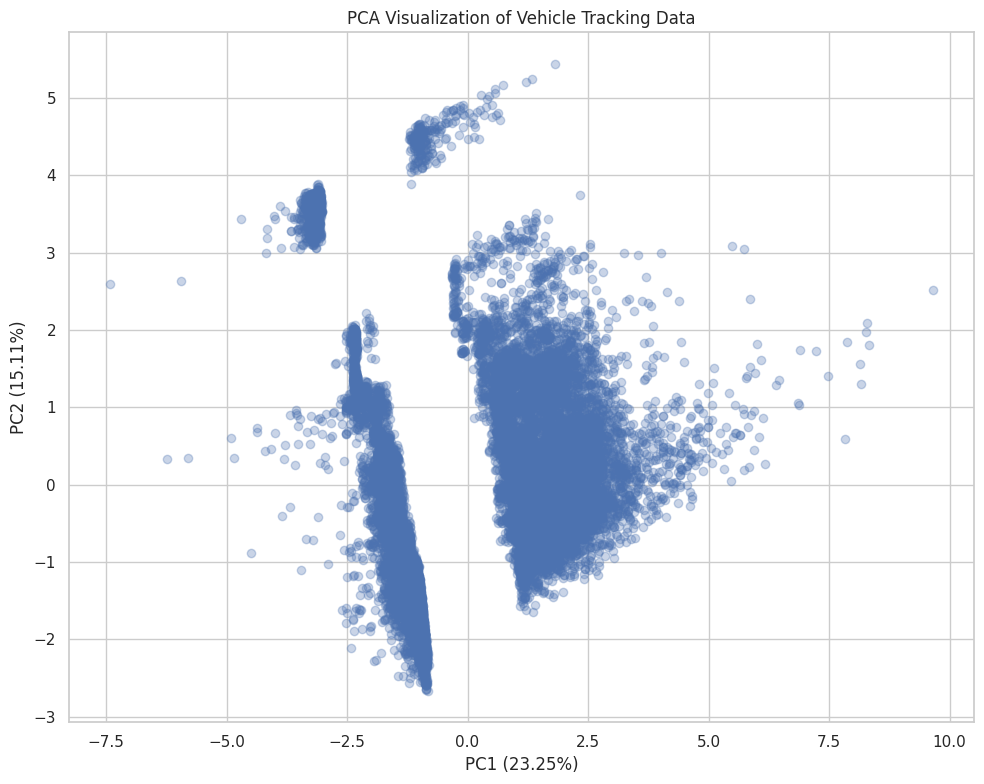

In [58]:

print("\n--- Dimensionality Reduction with PCA ---")

# Apply PCA for visualization and to reduce dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Show explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by 2 principal components: {sum(explained_variance)*100:.2f}%")
print(f"Individual components: PC1 {explained_variance[0]*100:.2f}%, PC2 {explained_variance[1]*100:.2f}%")

# Visualize PCA results
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3)
plt.title('PCA Visualization of Vehicle Tracking Data')
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)')
plt.tight_layout()
plt.show()

**PENJELASAN**: Grafik diatas merupakan hasil analisa metode (Principal Component Analysis) PCA dengan menggunakan 2 komponen utama yang menghasilkan:
1. PC1 menyumbang -+ 23.25% dari varians
2. PC2 menyumbang -+ 15.11% dari varians

Dan juga menunjukkan distribusi data yang beberapa kelompok berbeda, dan kelompok-kelompok ini kemungkinan mewakili pola atau behavior kendaraan yang berbeda. 

### Clustering Analysis using K-Means


--- Clustering Analysis ---
Applying K-means clustering...


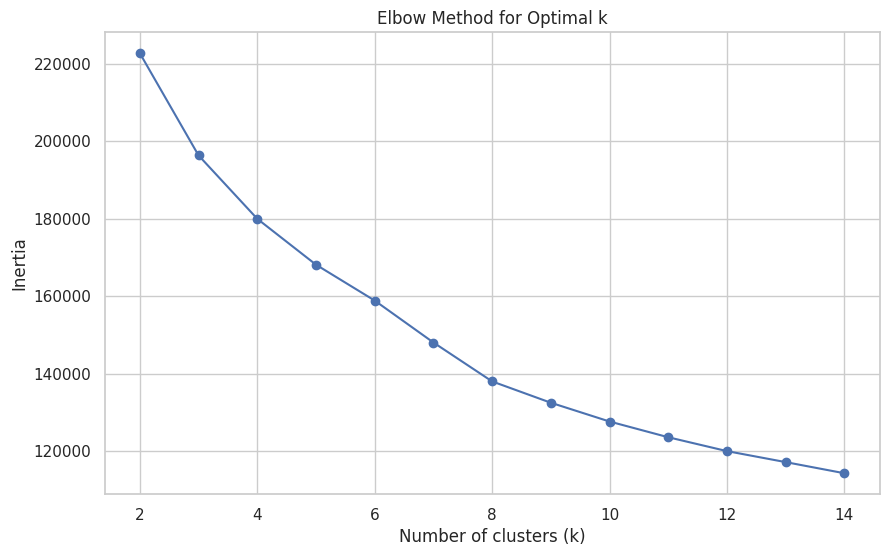

K-means Silhouette Score: 0.212


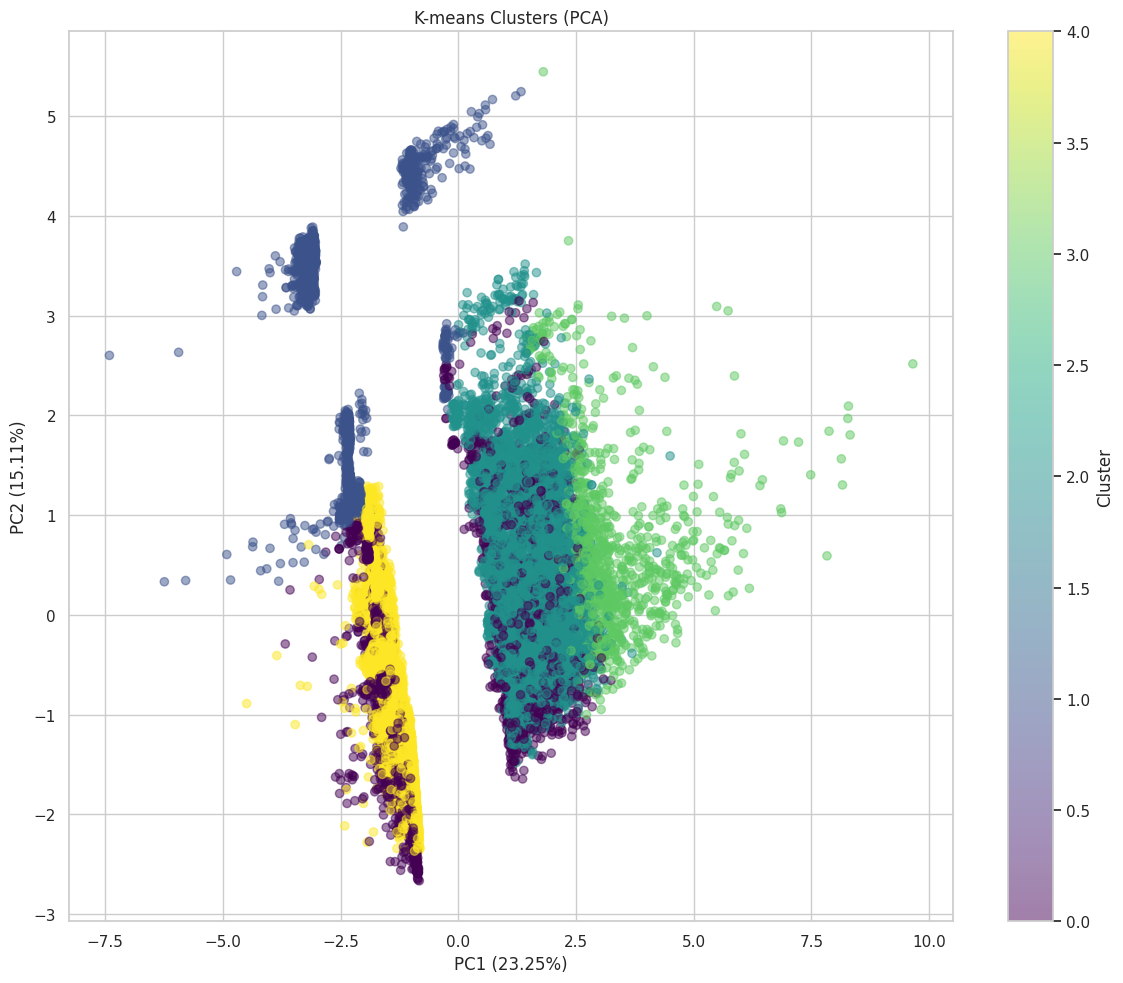

In [ ]:
print("\n--- Clustering Analysis ---")

print("Applying K-means clustering...")

inertia = []
k_range = range(2, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow method results
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

optimal_k = 5 # Trial and error
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data_clean['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

kmeans_silhouette = silhouette_score(X_scaled, data_clean['kmeans_cluster'])
print(f"K-means Silhouette Score: {kmeans_silhouette:.3f}")

plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_clean['kmeans_cluster'],
                      cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.title('K-means Clusters (PCA)')
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)')
plt.tight_layout()
plt.show()

**PENJELASAN**: Grafik diatas merupakan hasil analisa metode K-Means Custer (Principal Component Analysis) PCA yang menghasilkan 4 cluster dengan warna yang berbeda:
1. Cluster biru (1.0) di bagian kiri atas
2. Cluster kuning (4.0) di bagian kiri bawah
3. Cluster hijau (3.0) di bagian kanan
3. Cluster cyan/biru muda (2.0) di bagian tengah

Dari hasil Silhouette yang Rendah di 0.212 menunjukkan indikasi terjadinya overlap antara cluster.

## Result and Analysis

### Cluster Analysis and Interpretation


--- Cluster Analysis and Interpretation ---

Cluster characteristics:


,duration_seconds,distance_km,hour_of_day,day_of_week,is_weekend,unit_activity_count,activity_Trip,activity_Parking,speed_kmh,count
cluster,,,,,,,,,,
0,5739.232893,2.123177,8.962366,5.459433,1.000000,372.860215,0.490714,0.509286,5.638826,4092
1,9095.461875,0.271986,9.734337,2.700340,0.200097,405.563380,0.135988,0.864012,0.724363,2059
2,1300.470351,4.887746,9.760323,1.980751,0.000000,376.221515,1.000000,0.000000,11.770681,6442
3,7018.888434,43.445896,9.642784,2.836233,0.230297,326.496418,1.000000,0.000000,22.802807,977
4,6760.033593,0.000000,9.812131,2.002022,0.000000,371.936703,0.000000,1.000000,0.000000,6430


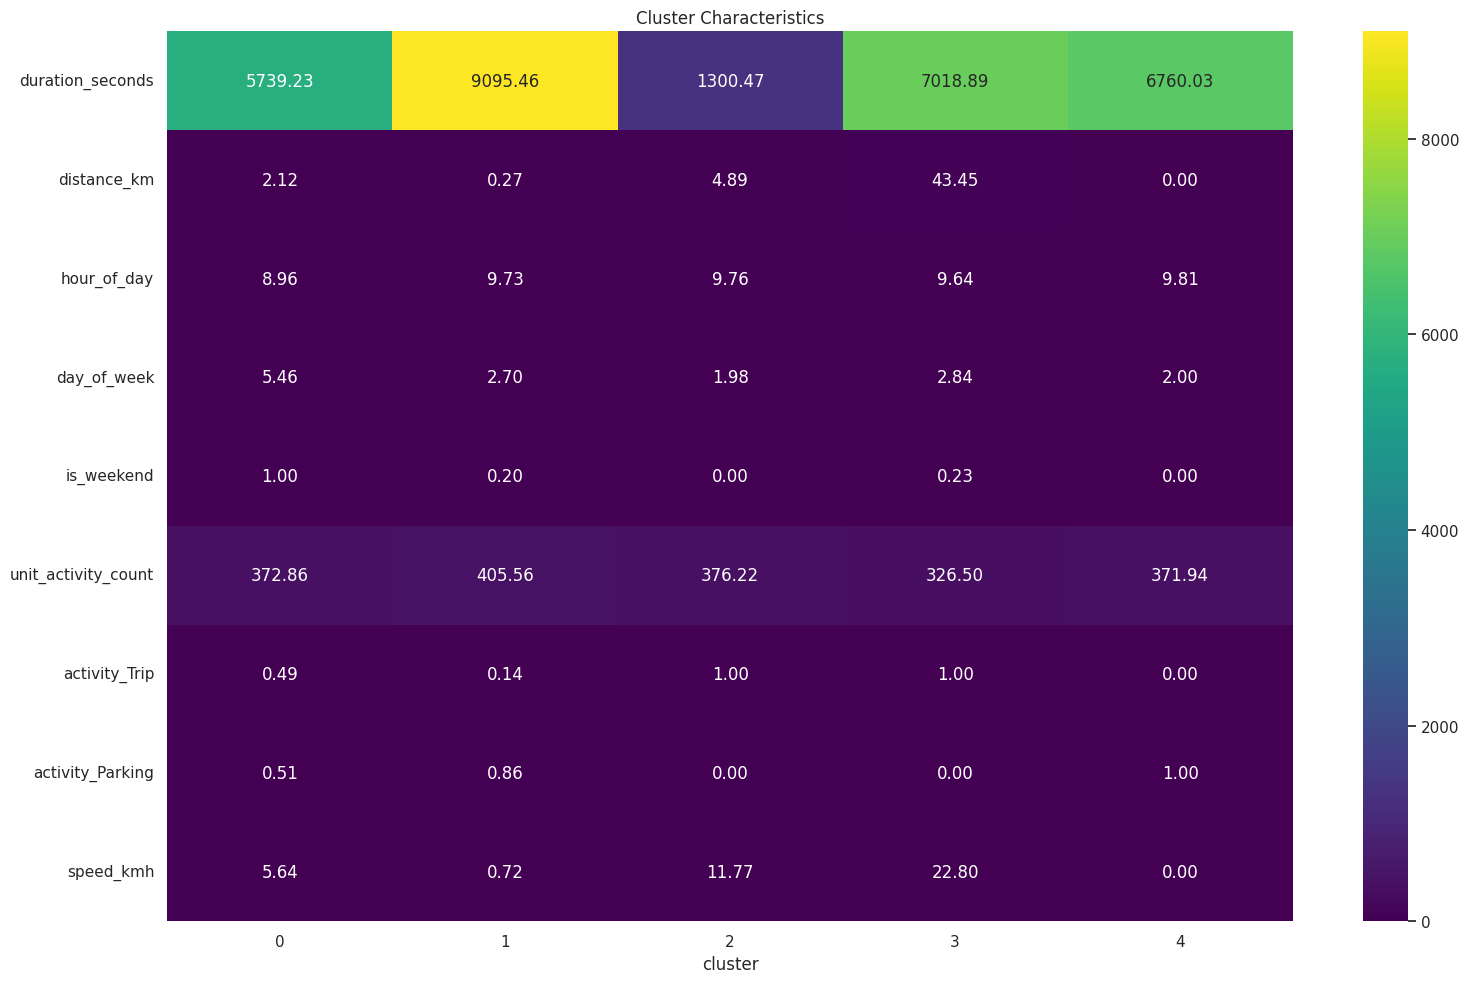

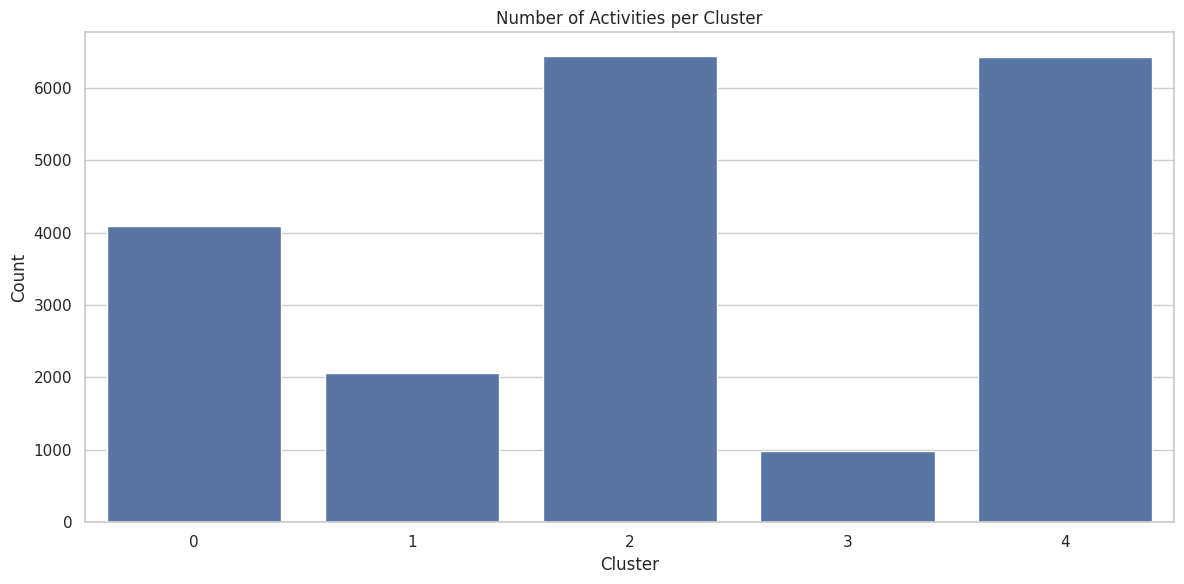

In [60]:
print("\n--- Cluster Analysis and Interpretation ---")

# Choose the best performing clustering method
# For this example, let's use K-means
best_clusters = data_clean['kmeans_cluster']
data_clean['cluster'] = best_clusters

# Analyze cluster characteristics
cluster_analysis = data_clean.groupby('cluster').agg({
    'duration_seconds': 'mean',
    'distance_km': 'mean',
    'hour_of_day': 'mean',
    'day_of_week': 'mean',
    'is_weekend': 'mean',
    'unit_activity_count': 'mean',
    'activity_Trip': 'mean',
    'activity_Parking': 'mean',
    'speed_kmh': 'mean',
    'UNIT': 'count'
}).rename(columns={'UNIT': 'count'})

print("\nCluster characteristics:")
display(cluster_analysis)

# Visualize cluster characteristics
plt.figure(figsize=(16, 10))
sns.heatmap(cluster_analysis.drop('count', axis=1).T, annot=True, cmap='viridis', fmt='.2f')
plt.title('Cluster Characteristics')
plt.tight_layout()
plt.show()

# Visualize cluster sizes
plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_analysis.index, y=cluster_analysis['count'])
plt.title('Number of Activities per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Vehicle Behavior Analysis


--- Vehicle Behavior Analysis ---

Vehicle behavior analysis:


,UNIT,duration_seconds_mean,distance_km_sum,distance_km_mean,speed_kmh_mean,activity_Trip_sum,activity_Parking_sum,cluster_<lambda>
0,O5121DT089,7109.679452,6345.45,8.692397,7.372161,363,367,4
1,O5121DT094,8784.720455,3053.54,6.939864,8.156862,201,239,4
2,O5121DT096,9320.258197,1057.49,4.333975,9.077717,127,117,2
3,O5121DT098,8996.028112,850.76,3.416707,6.256931,117,132,4
4,O5121DT100,6844.288344,413.90,2.539264,5.837357,85,78,2


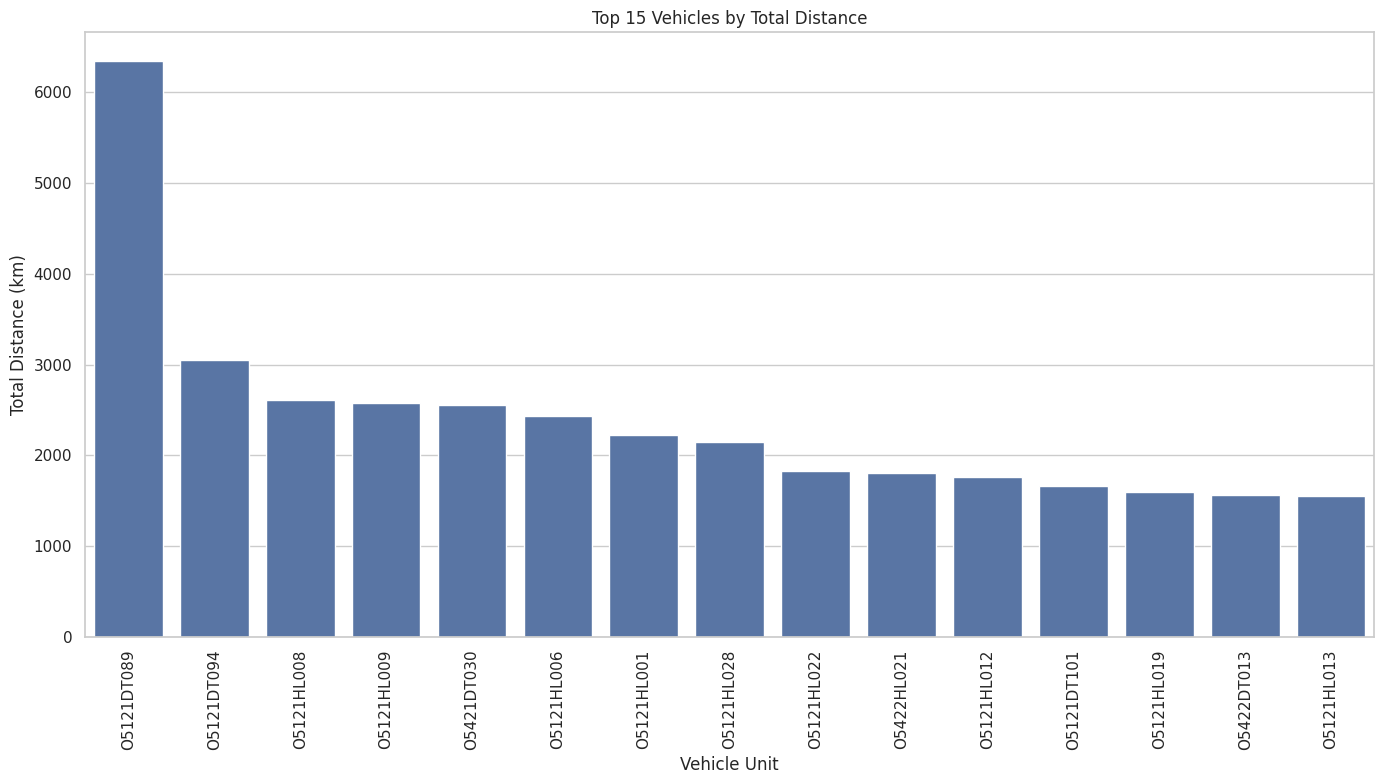

In [61]:
print("\n--- Vehicle Behavior Analysis ---")

# Analyze behavior patterns by unit
unit_analysis = data_clean.groupby('UNIT').agg({
    'duration_seconds': 'mean',
    'distance_km': ['sum', 'mean'],
    'speed_kmh': 'mean',
    'activity_Trip': 'sum',
    'activity_Parking': 'sum',
    'cluster': lambda x: x.mode()[0] if not x.mode().empty else -1
}).reset_index()

# Flatten the multi-level columns
unit_analysis.columns = ['_'.join(col).strip('_') for col in unit_analysis.columns.values]

# Display unit analysis
print("\nVehicle behavior analysis:")
display(unit_analysis.head())

# Plot top vehicles by total distance
top_n = 15
plt.figure(figsize=(14, 8))
top_units = unit_analysis.nlargest(top_n, 'distance_km_sum')
sns.barplot(x='UNIT', y='distance_km_sum', data=top_units)
plt.title(f'Top {top_n} Vehicles by Total Distance')
plt.xlabel('Vehicle Unit')
plt.ylabel('Total Distance (km)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Location-based Analysis


--- Location-based Analysis ---

Top 10 parking locations:


,count
INITIAL_LOCATION,
PT_2GHTI26CT2,594
PT_JSJ919,538
MILL,345
PT_2GHTI23CT4,288
DLJ2_NP0_U09FC6,274
PT_2GHTI26CT6,255
PT_732LOP,239
PT_2GHTJ18CT3,235
GUDANG,219


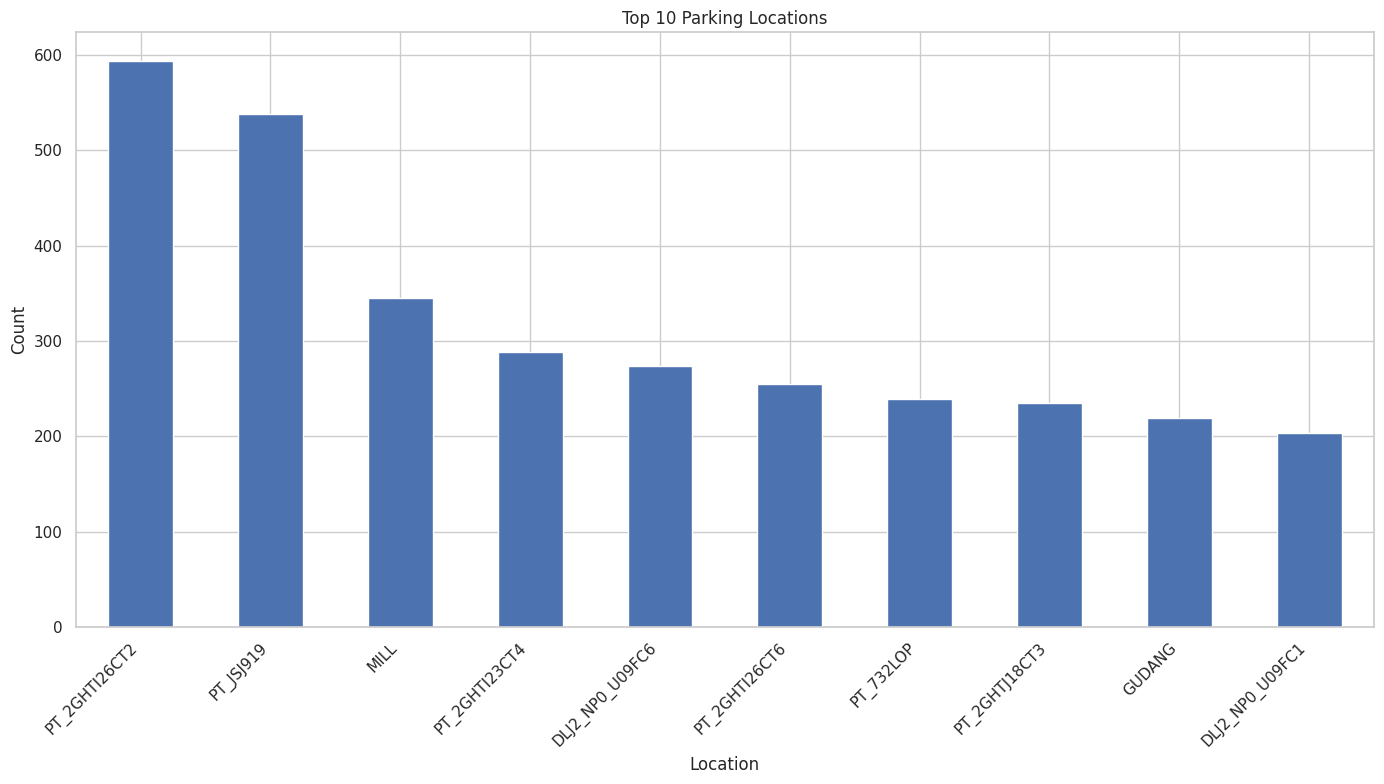


Top 10 trip routes:


,count
route_str,
PT_JSJ919 → PT_JSJ919,110
PT_2GHTI26CT2 → PT_2GHTI26CT2,107
MILL → MILL,93
PT_2GHTI23CT4 → PT_2GHTI23CT4,75
DLJ2_NP0_U09FC6 → DLJ2_NP0_U09FC6,69
PT_2GHTI26CT2 → GUDANG,60
PT_JSJ919 → PT_2GHTI26CT2,49
GUDANG → GUDANG,45
PT_732LOP → PT_732LOP,44


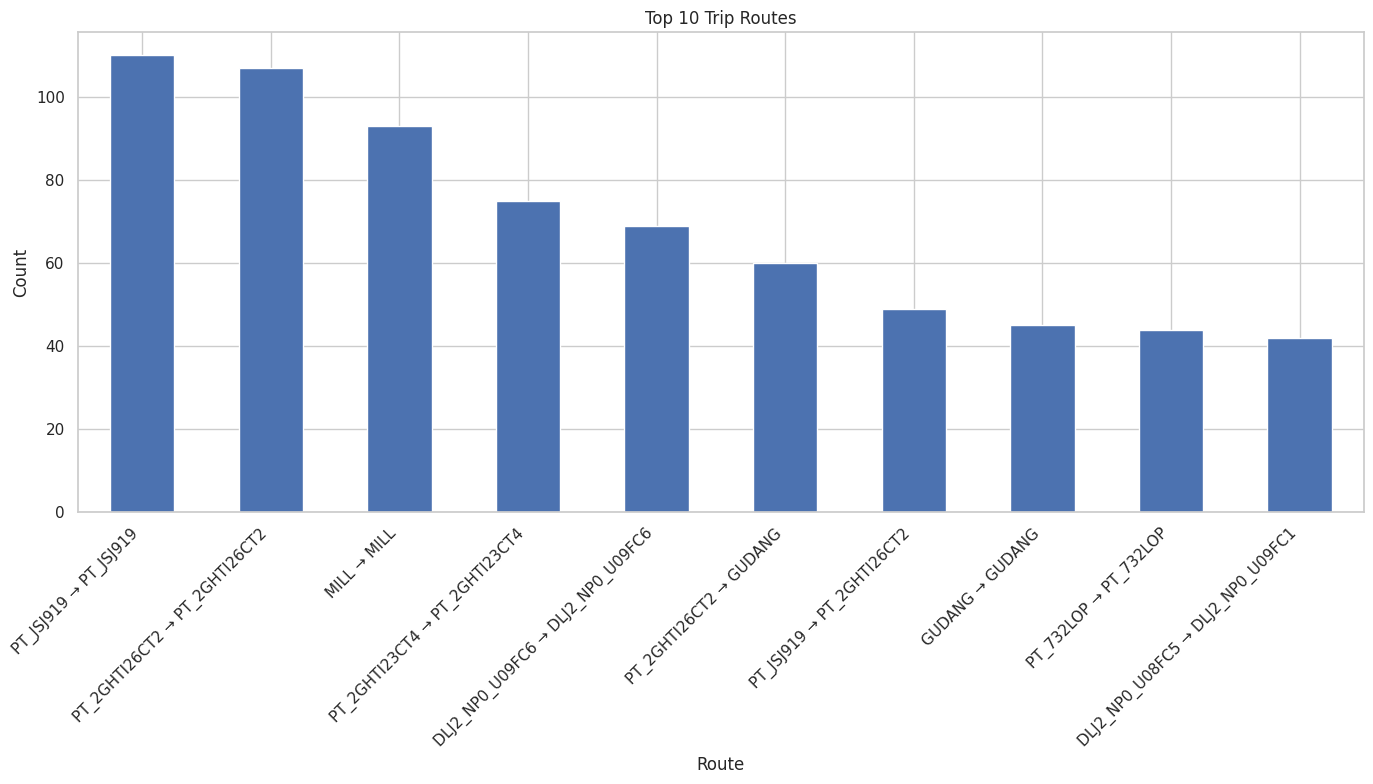

In [63]:
print("\n--- Location-based Analysis ---")

# Analyze most common parking locations
if 'activity_Parking' in data_clean.columns:
    parking_data = data_clean[data_clean['activity_Parking'] == 1]

    top_parking_locations = parking_data['INITIAL_LOCATION'].value_counts().head(10)
    print("\nTop 10 parking locations:")
    display(top_parking_locations)

    # Visualize top parking locations
    plt.figure(figsize=(14, 8))
    top_parking_locations.plot(kind='bar')
    plt.title('Top 10 Parking Locations')
    plt.xlabel('Location')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Analyze most common trip routes
if 'activity_Trip' in data_clean.columns:
    trip_data = data_clean[data_clean['activity_Trip'] == 1]

    # Create route strings
    trip_data['route_str'] = trip_data['INITIAL_LOCATION'] + ' → ' + trip_data['FINAL_LOCATION']
    top_routes = trip_data['route_str'].value_counts().head(10)

    print("\nTop 10 trip routes:")
    display(top_routes)

    # Visualize top routes
    plt.figure(figsize=(14, 8))
    top_routes.plot(kind='bar')
    plt.title('Top 10 Trip Routes')
    plt.xlabel('Route')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# If coordinates are available, plot on a map
if 'init_lat' in data_clean.columns and data_clean['init_lat'].notna().any():
    print("\nCreating map visualization...")

    # Get a sample of trip data for visualization (to avoid cluttering the map)
    sample_trips = trip_data.sample(min(100, len(trip_data)))

    # Create a map centered at the mean coordinates
    center_lat = sample_trips['init_lat'].mean()
    center_lon = sample_trips['init_lon'].mean()

    m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

    # Add trip lines
    for _, row in sample_trips.iterrows():
        folium.PolyLine(
            locations=[
                [row['init_lat'], row['init_lon']],
                [row['final_lat'], row['final_lon']]
            ],
            color='blue',
            weight=2,
            opacity=0.7
        ).add_to(m)

    # Add cluster markers for parking locations
    for cluster in data_clean['kmeans_cluster'].unique():
        cluster_data = data_clean[(data_clean['kmeans_cluster'] == cluster) &
                                 (data_clean['activity_Parking'] == 1)]

        if len(cluster_data) > 0:
            # Calculate centroid of parking locations for this cluster
            cluster_lat = cluster_data['init_lat'].mean()
            cluster_lon = cluster_data['init_lon'].mean()

            folium.CircleMarker(
                location=[cluster_lat, cluster_lon],
                radius=10,
                color=f'#{hash(cluster) % 0xffffff:06x}',
                fill=True,
                fill_opacity=0.5,
                popup=f'Cluster {cluster}: {len(cluster_data)} parking events'
            ).add_to(m)

    # Save the map
    m.save('vehicle_tracking_map.html')
    print("Map saved as 'vehicle_tracking_map.html'")

Dari hasil analisis diatas dapat diambil beberapa kesimpulan seperti:
1. Unit kendaraan `O5121DT089` mempunyai jarak tempuh trip paling tinggi yaitu 6345.45 KM, dari hasil tersebut bisa diberikan saran untuk pengecekan dan maintenance dari kendaraan tersebut.
2. Titik parkir awal `PT_2GHTI26CT2` menjadi titik awal yang paling sering untuk ditempati oleh unit kendaraan, sehingga mungkin pengembangan infrastruktur dari tempat parkir tersebut bisa dilakukan demi keamanan dan kenyamanan pengemudi/karyawan.
3. Rute perjalanan `PT_2GHTI26CT2 → GUDANG` menjadi rute yang sering dilakukan dalam perpindahan site.